<ipython-input-1-5b4def735fd8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


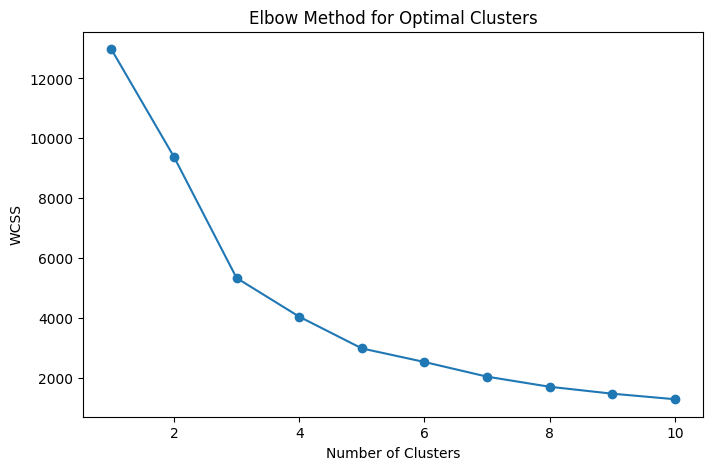

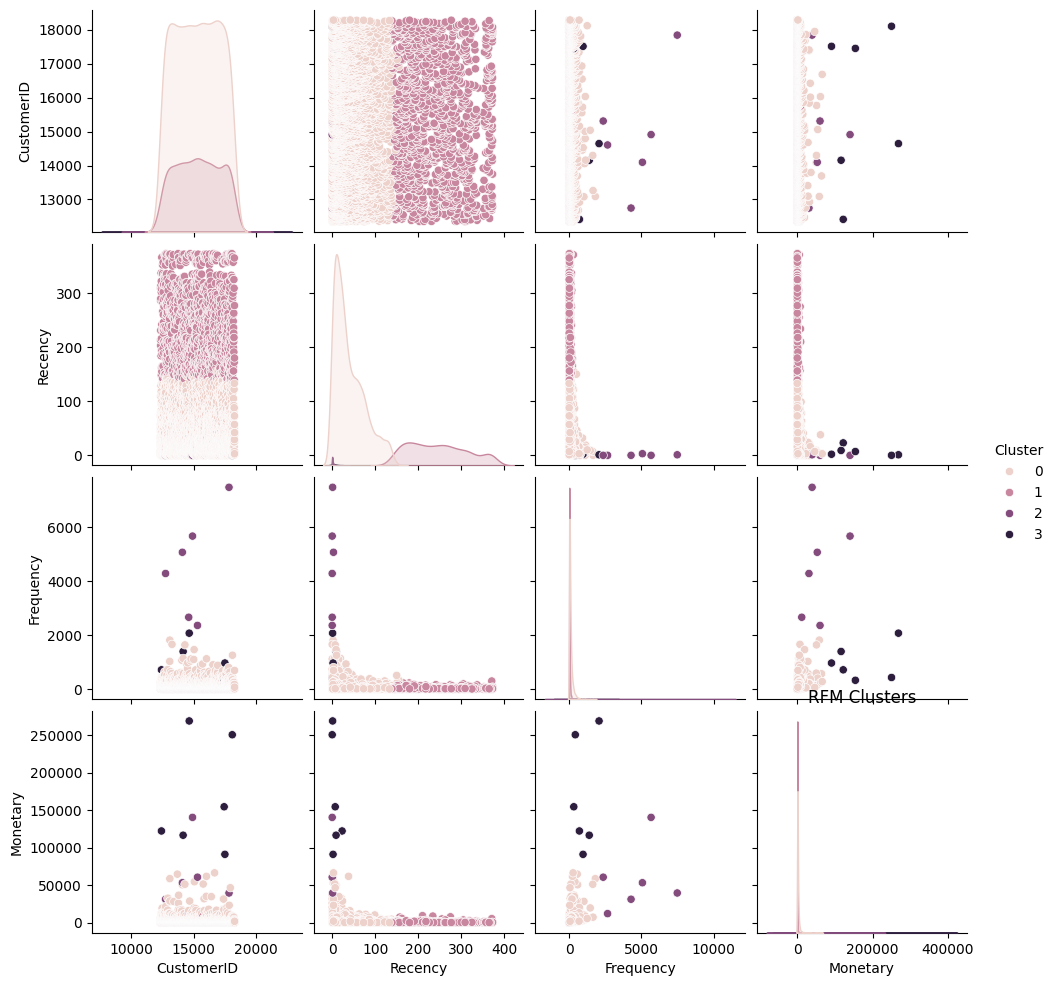


Logistic Regression
Confusion Matrix:
[[583   0]
 [  0 283]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       583
           1       1.00      1.00      1.00       283

    accuracy                           1.00       866
   macro avg       1.00      1.00      1.00       866
weighted avg       1.00      1.00      1.00       866


Random Forest
Confusion Matrix:
[[583   0]
 [  0 283]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       583
           1       1.00      1.00      1.00       283

    accuracy                           1.00       866
   macro avg       1.00      1.00      1.00       866
weighted avg       1.00      1.00      1.00       866


Gradient Boosting
Confusion Matrix:
[[583   0]
 [  0 283]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00 

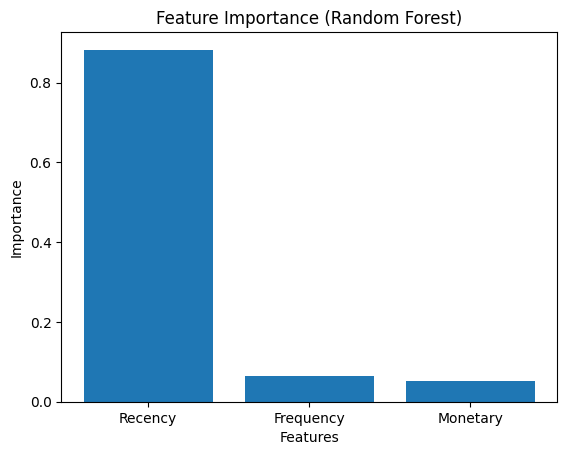

Silhouette Score for K-Means Clustering: 0.6010493502341662


In [ ]:
coll# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (already preprocessed)
df = pd.read_csv('processed_data.csv')

# Ensure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter for positive Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Calculate TotalPrice (already done but ensure it's consistent)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# ==================================
# 1. RFM Analysis
# ==================================
# Define a reference date for Recency calculation
reference_date = df['InvoiceDate'].max()

# Calculate Recency, Frequency, and Monetary metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                     # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Remove customers with Monetary <= 0 (if applicable)
rfm = rfm[rfm['Monetary'] > 0]

# ==================================
# 2. K-Means Clustering for Customer Segmentation
# ==================================
# Normalize RFM metrics for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with optimal clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
sns.pairplot(rfm, hue='Cluster', diag_kind='kde')
plt.title('RFM Clusters')
plt.show()

# ==================================
# 3. Predictive Modeling: Churn Prediction
# ==================================
# Define churn based on Recency (e.g., > 90 days is churned)
rfm['Churn'] = (rfm['Recency'] > 90).astype(int)

# Features and target
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate models
models = {
    'Logistic Regression': logistic_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

for name, model in models.items():
    print(f"\n{name}")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# ==================================
# 4. Feature Importance (Random Forest)
# ==================================
importances = rf_model.feature_importances_
plt.bar(X.columns, importances)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# ==================================
# 5. Silhouette Score for Clustering Validation
# ==================================
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg}")